# Importing Libraries

In [1]:
# Importing all the neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import IFrame
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

/workspaces/Weather-Trend-Forecasting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Dataset

In [2]:
print("Loading the Global Weather Repository dataset...")
try:
    file_path = "GlobalWeatherRepository.csv"
    df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "nelgiriyewithana/global-weather-repository", file_path)
    print(f"Dataset loaded successfully with shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Attempting to load from local file if available...")
    try:
        df = pd.read_csv("GlobalWeatherRepository.csv")
        print(f"Dataset loaded from local file with shape: {df.shape}")
    except:
        print("Please download the dataset from Kaggle and place it in the working directory")
        print("URL: https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository")
        exit()

Loading the Global Weather Repository dataset...
Dataset loaded successfully with shape: (60023, 41)


In [3]:
# Showing general information of dataset
print("Basic dataset information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nData types:")
print(df.dtypes)

Basic dataset information:
Number of rows: 60023
Number of columns: 41

Data types:
country                          object
location_name                    object
latitude                        float64
longitude                       float64
timezone                         object
last_updated_epoch                int64
last_updated                     object
temperature_celsius             float64
temperature_fahrenheit          float64
condition_text                   object
wind_mph                        float64
wind_kph                        float64
wind_degree                       int64
wind_direction                   object
pressure_mb                     float64
pressure_in                     float64
precip_mm                       float64
precip_in                       float64
humidity                          int64
cloud                             int64
feels_like_celsius              float64
feels_like_fahrenheit           float64
visibility_km                   floa

# Data Cleaning and Preprocessing

In [4]:
print("Data Cleaning & Preprocessing")

# Checking for missing values
print("Missing values in each column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Data Cleaning & Preprocessing
Missing values in each column:
Series([], dtype: int64)


In [5]:
# Function to handle missing values
def handle_missing_values(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())
    
    return df

In [6]:
# Converting datetime columns
print("Converting datetime columns...")
df['last_updated'] = pd.to_datetime(df['last_updated'])
# Extracting components for time series analysis
df['date'] = df['last_updated'].dt.date
df['year'] = df['last_updated'].dt.year
df['month'] = df['last_updated'].dt.month
df['day'] = df['last_updated'].dt.day
df['day_of_week'] = df['last_updated'].dt.dayofweek
df['hour'] = df['last_updated'].dt.hour

Converting datetime columns...


In [7]:
# Handling missing values
df = handle_missing_values(df)
print(f"Missing values after cleaning: {df.isnull().sum().sum()}")

Missing values after cleaning: 0


In [8]:
# Checking for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed duplicates. New shape: {df.shape}")

Number of duplicate rows: 0


In [9]:
# Detecting and handling outliers using IsolationForest
def detect_and_handle_outliers(df, column):
    print(f"Detecting outliers in {column}...")
    data = df[column].values.reshape(-1, 1)
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    outliers = iso_forest.fit_predict(data)
    outlier_indices = np.where(outliers == -1)[0]
    print(f"Found {len(outlier_indices)} outliers in {column}\n")
    
    # Replace outliers with median
    median_value = df[column].median()
    df.loc[df.index[outlier_indices], column] = median_value
    return df

In [10]:
key_weather_columns = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm']
for column in key_weather_columns:
    df = detect_and_handle_outliers(df, column)

Detecting outliers in temperature_celsius...
Found 593 outliers in temperature_celsius

Detecting outliers in humidity...
Found 556 outliers in humidity

Detecting outliers in pressure_mb...
Found 558 outliers in pressure_mb

Detecting outliers in wind_kph...
Found 587 outliers in wind_kph

Detecting outliers in precip_mm...
Found 595 outliers in precip_mm



In [11]:
# Normalize numerical features for modeling
def normalize_data(df, columns_to_scale):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df_scaled, scaler

In [12]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
columns_to_scale = [col for col in numerical_cols if col not in ['last_updated_epoch', 'year', 'month', 'day', 'hour', 'day_of_week']]
df_scaled, scaler = normalize_data(df, columns_to_scale)
print("Normalizing the Data...")

Normalizing the Data...


# Exploratory Data Analysis

In [13]:
print("Performing Exploratory Data Analysis")

# Saving all the plots to plots directory
def save_plot(fig, filename):
    plt.tight_layout()
    plt.savefig("plots/" + filename)
    plt.show()
    plt.close()

Performing Exploratory Data Analysis


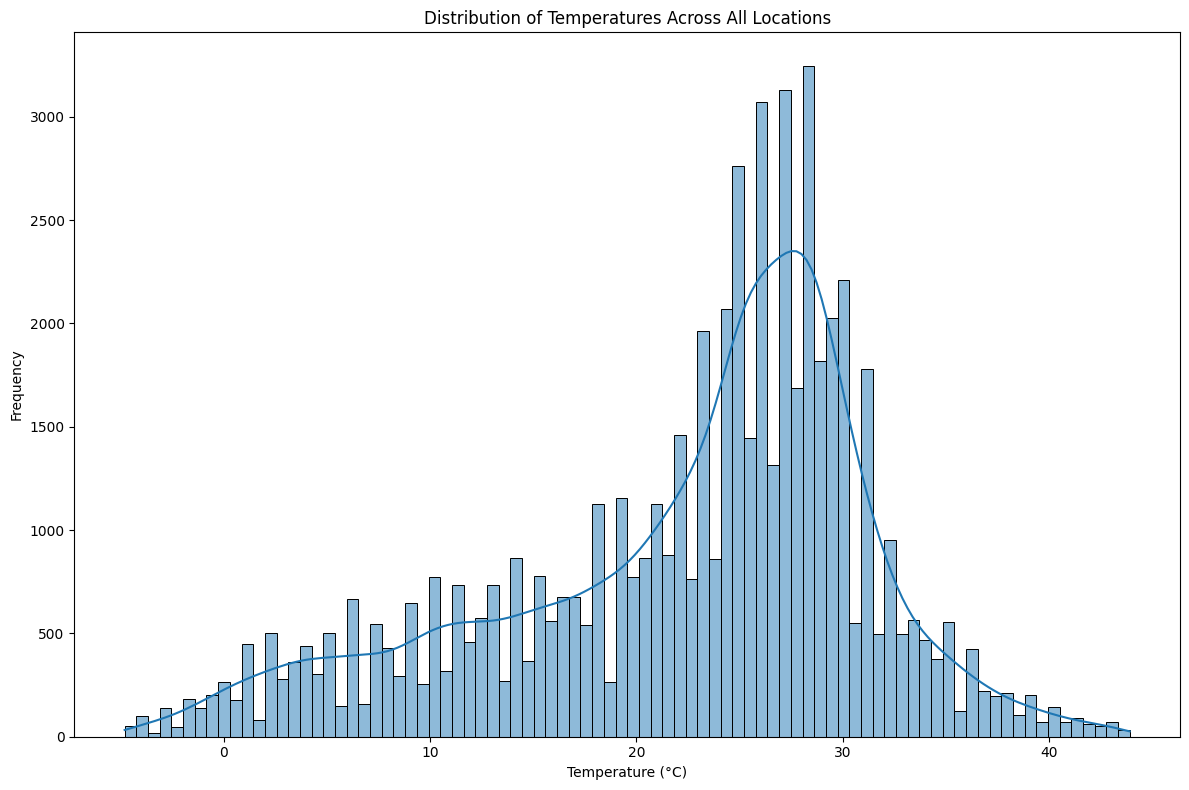

Created temperature distribution plot


In [14]:
# Distribution of temperatures across different regions
plt.figure(figsize=(12, 8))
sns.histplot(df['temperature_celsius'], kde=True)
plt.title('Distribution of Temperatures Across All Locations')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
save_plot(plt.gcf(), 'temperature_distribution.png')
print("Created temperature distribution plot")

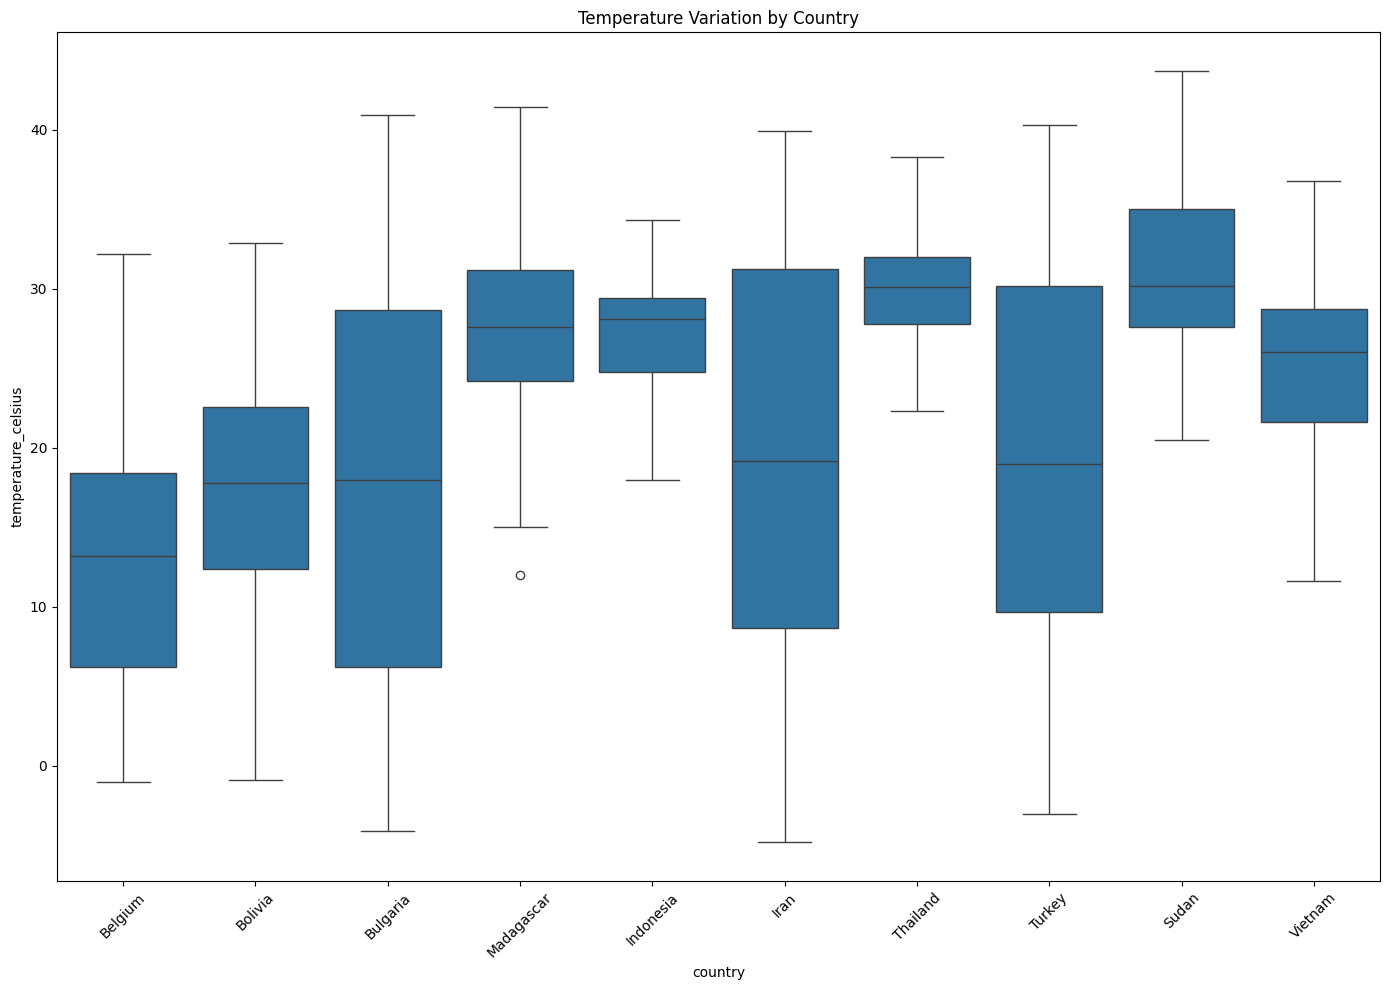

Created temperature by country plot


In [15]:
# Temperature variation by country, considering only top 10 
top_countries = df['country'].value_counts().head(10).index
plt.figure(figsize=(14, 10))
sns.boxplot(x='country', y='temperature_celsius', data=df[df['country'].isin(top_countries)])
plt.title('Temperature Variation by Country')
plt.xticks(rotation=45)
save_plot(plt.gcf(), 'temperature_by_country.png')
print("Created temperature by country plot")

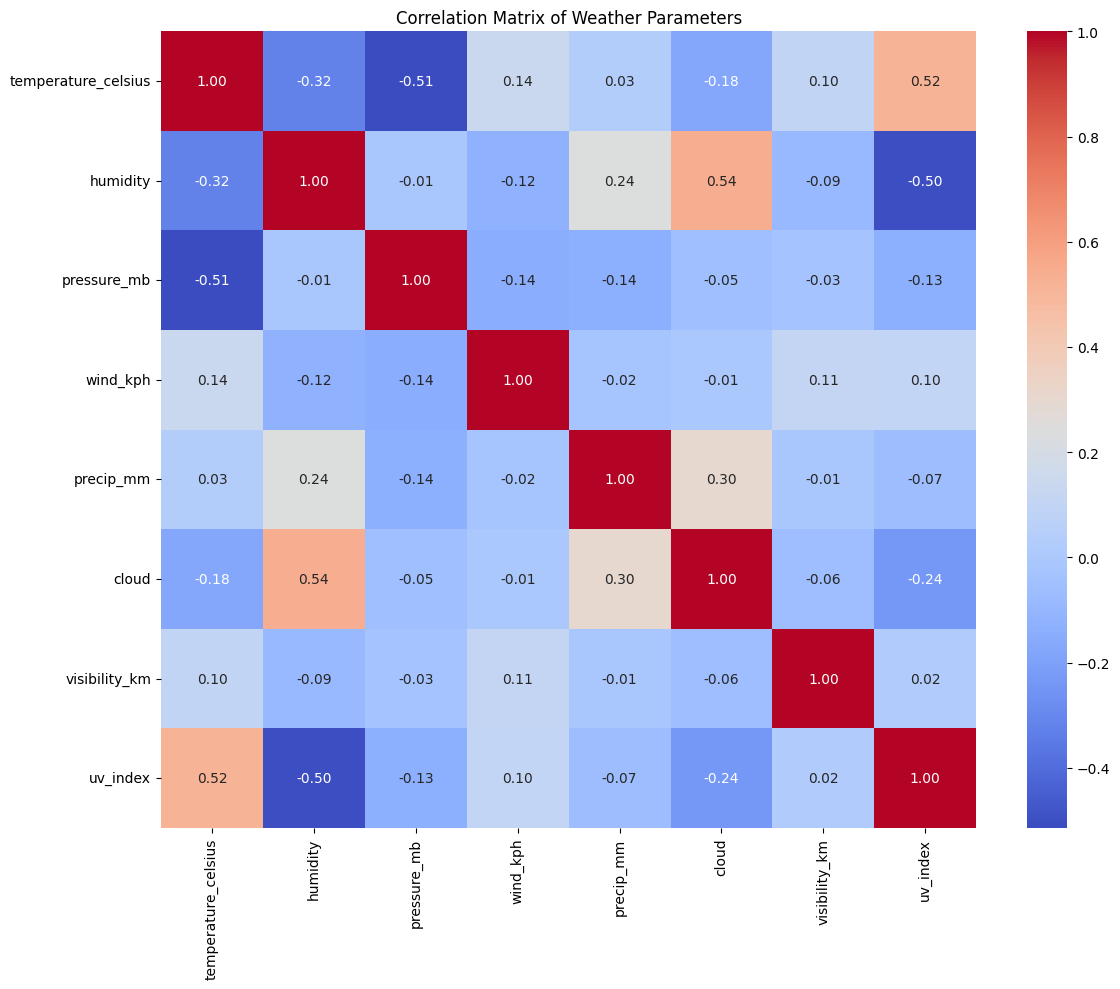

Created correlation matrix


In [16]:
# Correlation matrix
corr_columns = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud', 'visibility_km', 'uv_index']
corr_matrix = df[corr_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather Parameters')
save_plot(plt.gcf(), 'correlation_matrix.png')
print("Created correlation matrix")

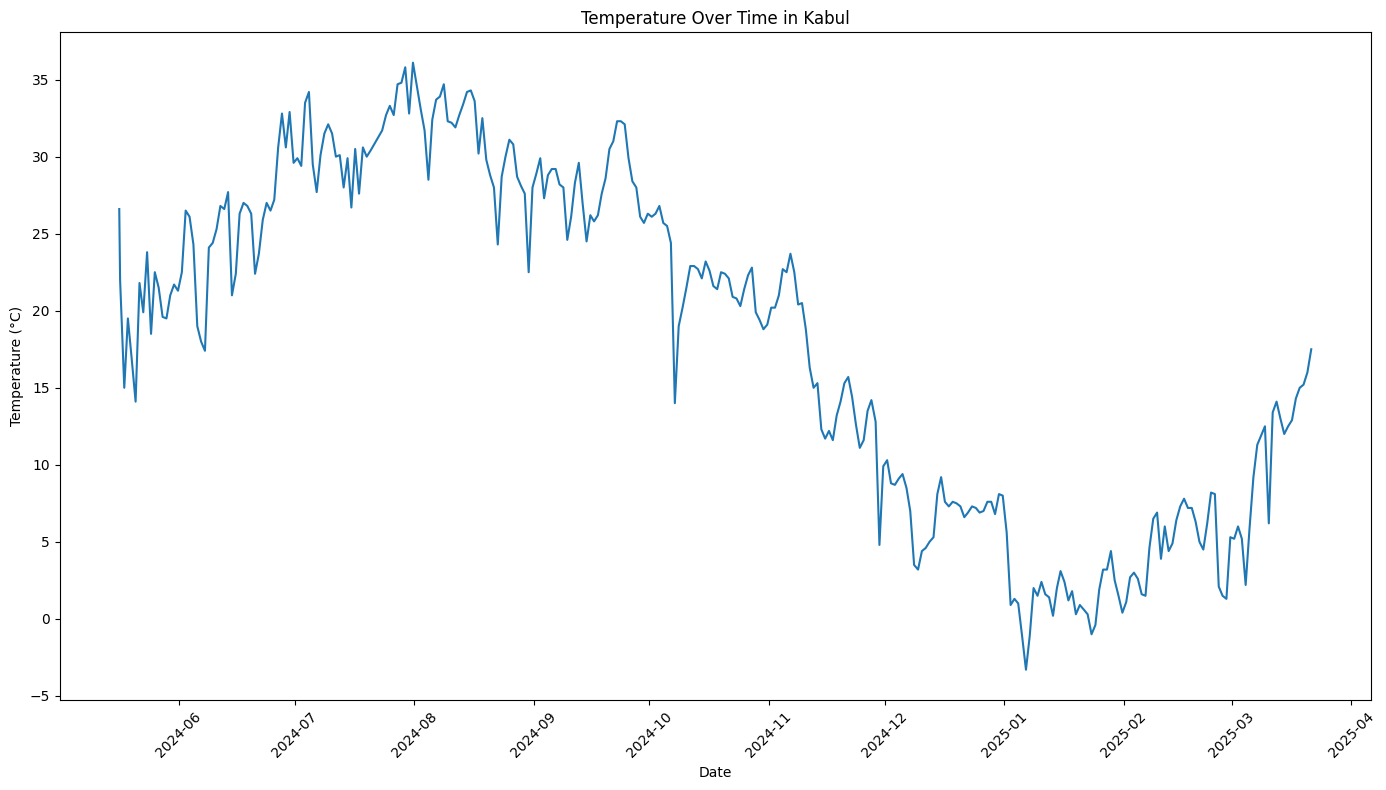

Created time series plot for Kabul


In [17]:
# Time series plot of temperature for a specific location
common_location = df['location_name'].value_counts().index[0]
location_info = df[df['location_name'] == common_location].sort_values('last_updated')
plt.figure(figsize=(14, 8))
plt.plot(location_info['last_updated'], location_info['temperature_celsius'])
plt.title(f'Temperature Over Time in {common_location}')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
save_plot(plt.gcf(), 'temperature_time_series.png')
print(f"Created time series plot for {common_location}")

In [18]:
# Advanced EDA: Anomaly Detection
print("Performing anomaly detection on temperature data...")
temp_data = df[['temperature_celsius']].values
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['temperature_anomaly'] = iso_forest.fit_predict(temp_data)
anomalies = df[df['temperature_anomaly'] == -1]
print(f"Detected {len(anomalies)} temperature anomalies")

Performing anomaly detection on temperature data...
Detected 2959 temperature anomalies


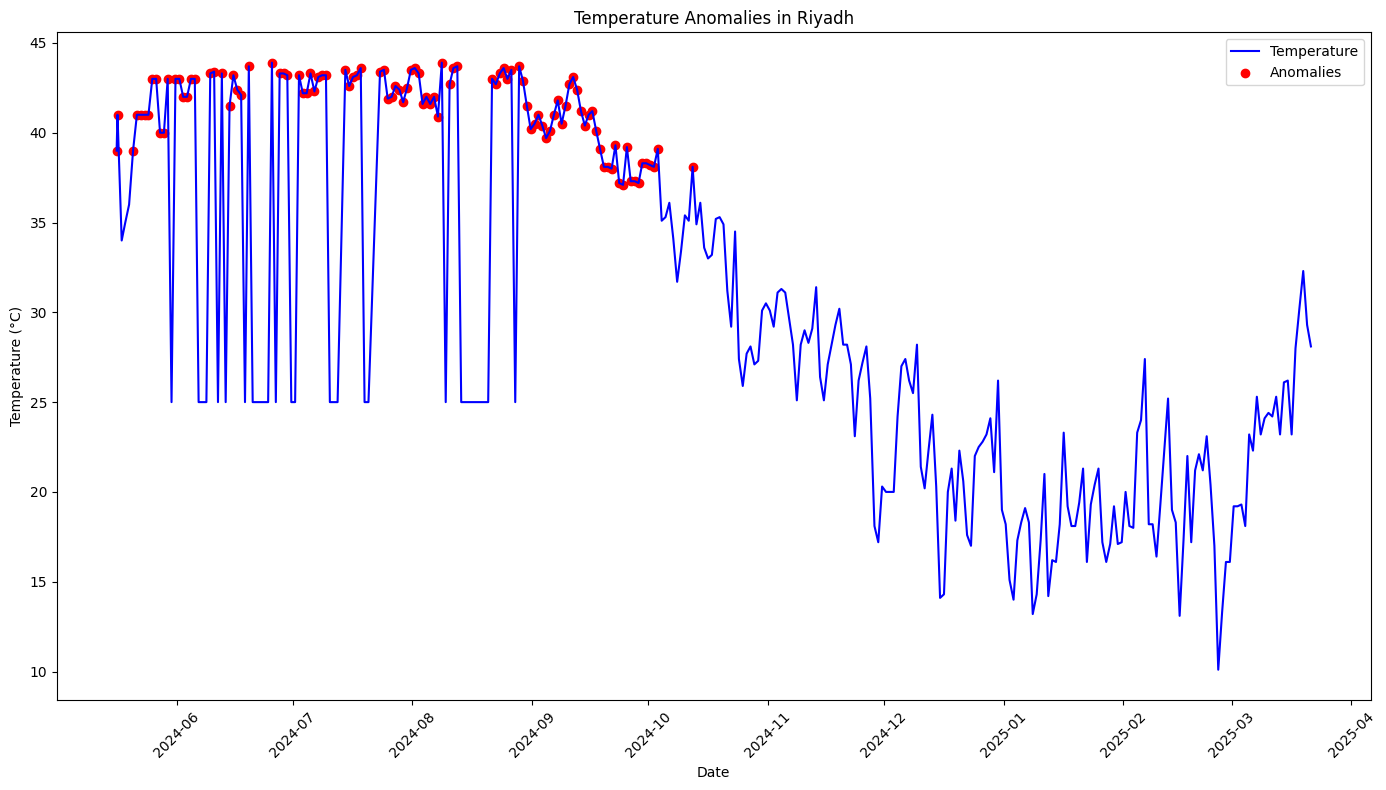

Created anomaly detection plot for Riyadh


In [19]:
# Plot anomalies for a sample location
if len(anomalies) > 0:
    sample_location = anomalies['location_name'].value_counts().index[0]
    loc_data = df[df['location_name'] == sample_location].sort_values('last_updated')
    plt.figure(figsize=(14, 8))
    plt.plot(loc_data['last_updated'], loc_data['temperature_celsius'], 'b-', label='Temperature')
    anomaly_data = loc_data[loc_data['temperature_anomaly'] == -1]
    plt.scatter(anomaly_data['last_updated'], anomaly_data['temperature_celsius'], color='red', label='Anomalies')
    plt.title(f'Temperature Anomalies in {sample_location}')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.xticks(rotation=45)
    save_plot(plt.gcf(), 'temperature_anomalies.png')
    print(f"Created anomaly detection plot for {sample_location}")

In [20]:
# Geographical patterns: Temperature distribution across different locations
plt.figure(figsize=(16, 12))
world_map = px.scatter_geo(df.drop_duplicates(subset=['location_name']),
                          lat='latitude',
                          lon='longitude',
                          color='temperature_celsius',
                          hover_name='location_name',
                          size='temperature_celsius',
                          size_max=10,
                          title='Global Temperature Distribution',
                          color_continuous_scale=px.colors.sequential.Plasma)
world_map.write_html('plots/' + 'temperature_map.html')
print("Created global temperature distribution map (HTML)")

Created global temperature distribution map (HTML)


<Figure size 1600x1200 with 0 Axes>

# Forecasting Models

In [21]:
print("Building Forecasting Models")

# Prepare dataset for time series forecasting also considering one location
forecast_location = common_location
forecast_data = df[df['location_name'] == forecast_location].copy()
forecast_data = forecast_data.sort_values('last_updated')
forecast_data.set_index('last_updated', inplace=True)

Building Forecasting Models


In [22]:
# Resample to daily data if there are multiple entries per day
daily_data = forecast_data['temperature_celsius'].resample('D').mean().reset_index()
daily_data = daily_data.rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
daily_data = daily_data.dropna()

In [23]:
print(f"Time series forecasting for {forecast_location}")
print(f"Time series data points: {len(daily_data)}")

Time series forecasting for Kabul
Time series data points: 308


In [24]:
# Split data into train and test sets
train_size = int(len(daily_data) * 0.8)
train_data = daily_data[:train_size]
test_data = daily_data[train_size:]
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 246
Test set size: 62


## Prophet Model

In [25]:
# Facebook Prophet Model
print("Training Facebook Prophet model...")
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
prophet_model.fit(train_data)

22:25:56 - cmdstanpy - INFO - Chain [1] start processing


Training Facebook Prophet model...


22:25:56 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Predictions
future = prophet_model.make_future_dataframe(periods=len(test_data))
prophet_forecast = prophet_model.predict(future)

In [27]:
# Evaluation metrics
prophet_pred = prophet_forecast.iloc[-len(test_data):]['yhat'].values
prophet_rmse = np.sqrt(mean_squared_error(test_data['y'], prophet_pred))
prophet_mae = mean_absolute_error(test_data['y'], prophet_pred)
print(f"Prophet RMSE: {prophet_rmse:.4f}")
print(f"Prophet MAE: {prophet_mae:.4f}")

Prophet RMSE: 6.5246
Prophet MAE: 5.5669


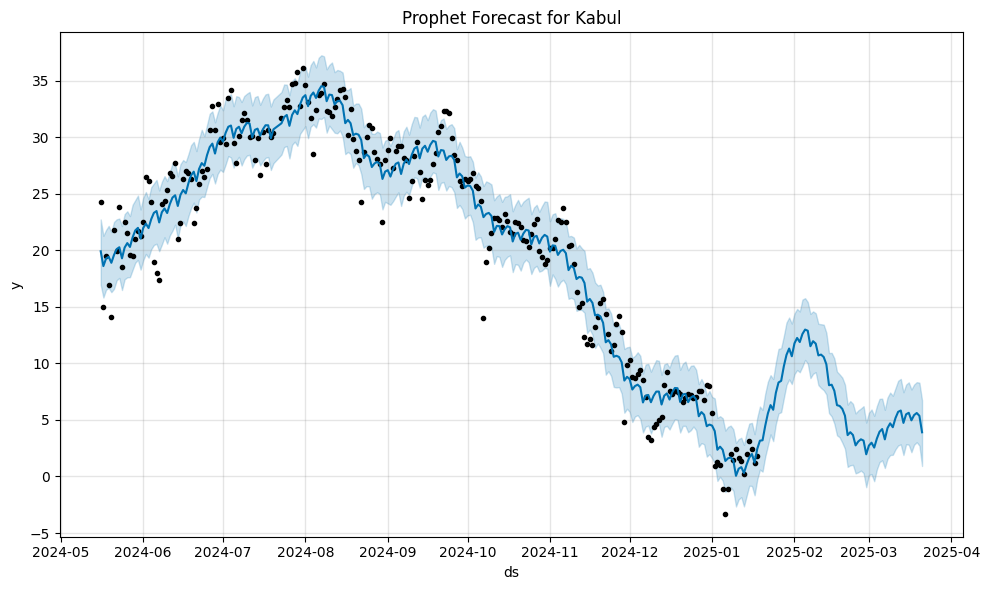

In [28]:
# Ploting Prophet forecast
fig1 = prophet_model.plot(prophet_forecast)
plt.title(f'Prophet Forecast for {forecast_location}')
save_plot(fig1, 'prophet_forecast.png')

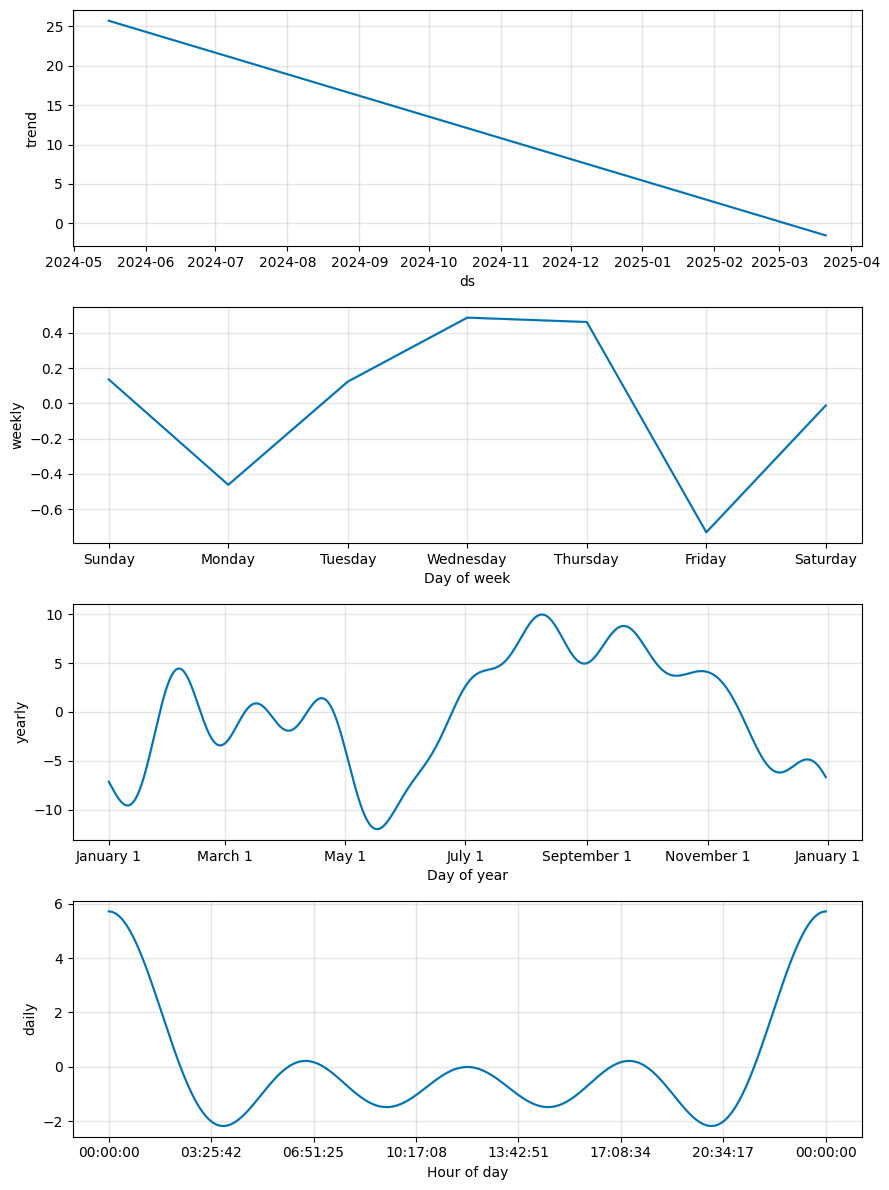

Created Prophet forecast and components plots


In [29]:
# Ploting all the Prophet components
fig2 = prophet_model.plot_components(prophet_forecast)
save_plot(fig2, 'prophet_components.png')
print("Created Prophet forecast and components plots")

## SARIMA Model

In [30]:
# SARIMA Model
print("\nTraining SARIMA model...")
sarima_model = SARIMAX(train_data['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit(disp=False)


Training SARIMA model...


In [31]:
# Prredictions and Evaluation metrics
sarima_pred = sarima_results.forecast(steps=len(test_data))
sarima_rmse = np.sqrt(mean_squared_error(test_data['y'], sarima_pred))
sarima_mae = mean_absolute_error(test_data['y'], sarima_pred)
print(f"SARIMA RMSE: {sarima_rmse:.4f}")
print(f"SARIMA MAE: {sarima_mae:.4f}")

SARIMA RMSE: 9.6338
SARIMA MAE: 7.7228


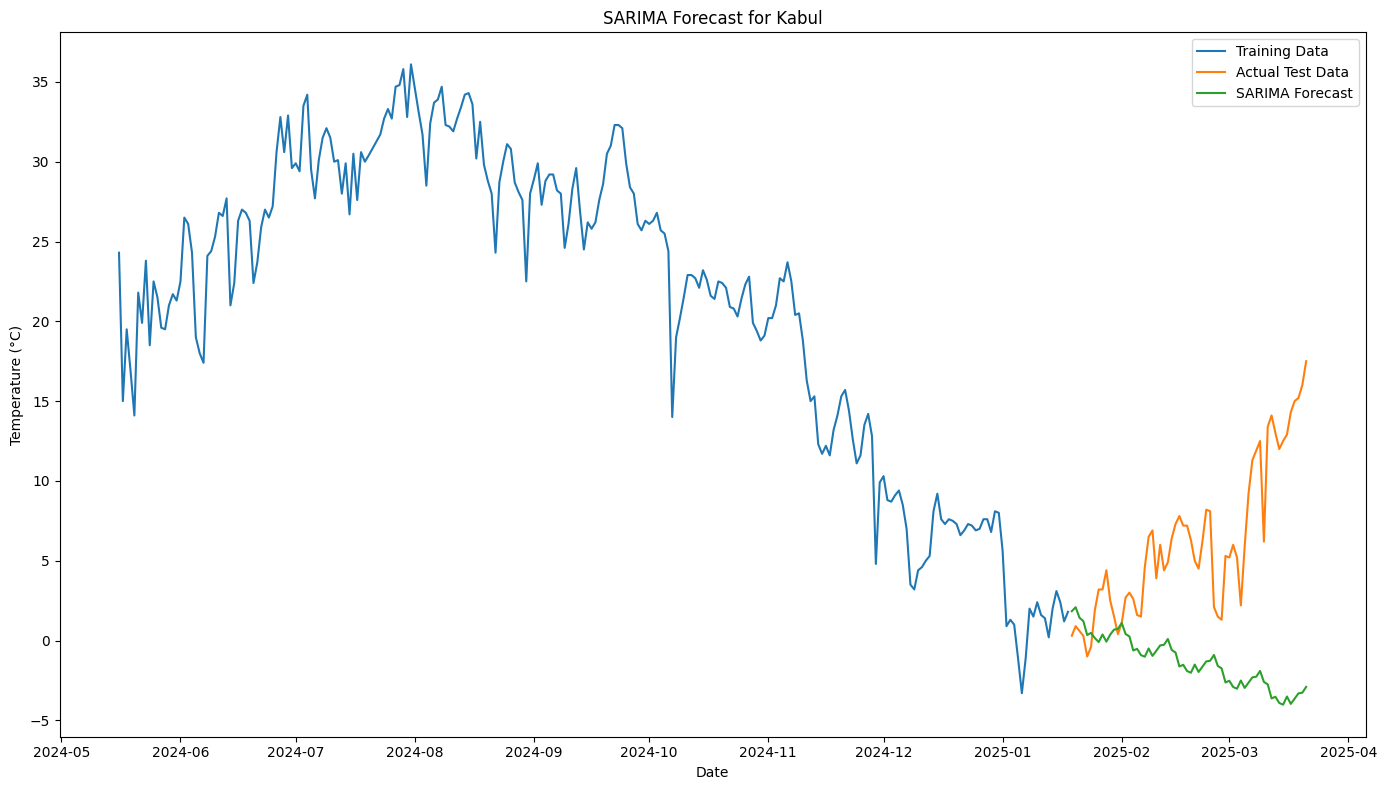

Created SARIMA forecast plot


In [32]:
# Ploting SARIMA forecast
plt.figure(figsize=(14, 8))
plt.plot(train_data['ds'], train_data['y'], label='Training Data')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data')
plt.plot(test_data['ds'], sarima_pred, label='SARIMA Forecast')
plt.title(f'SARIMA Forecast for {forecast_location}')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
save_plot(plt.gcf(), 'sarima_forecast.png')
print("Created SARIMA forecast plot")

## XGBoost Model

In [33]:
# XGBoost Model for Time Series
print("Training XGBoost model for time series...")
# Create time features for XGBoost
def create_features(df):
    df = df.copy()
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    return df

Training XGBoost model for time series...


In [34]:
# Add time-based features on train and test data
train_features = create_features(train_data)
test_features = create_features(test_data)

In [35]:
feature_columns = ['hour', 'dayofweek', 'month', 'year', 'dayofyear']
X_train = train_features[feature_columns]
y_train = train_features['y']
X_test = test_features[feature_columns]
y_test = test_features['y']

In [36]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [37]:
# Predictions and Evaluation metrics
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")

XGBoost RMSE: 6.4480
XGBoost MAE: 4.9111


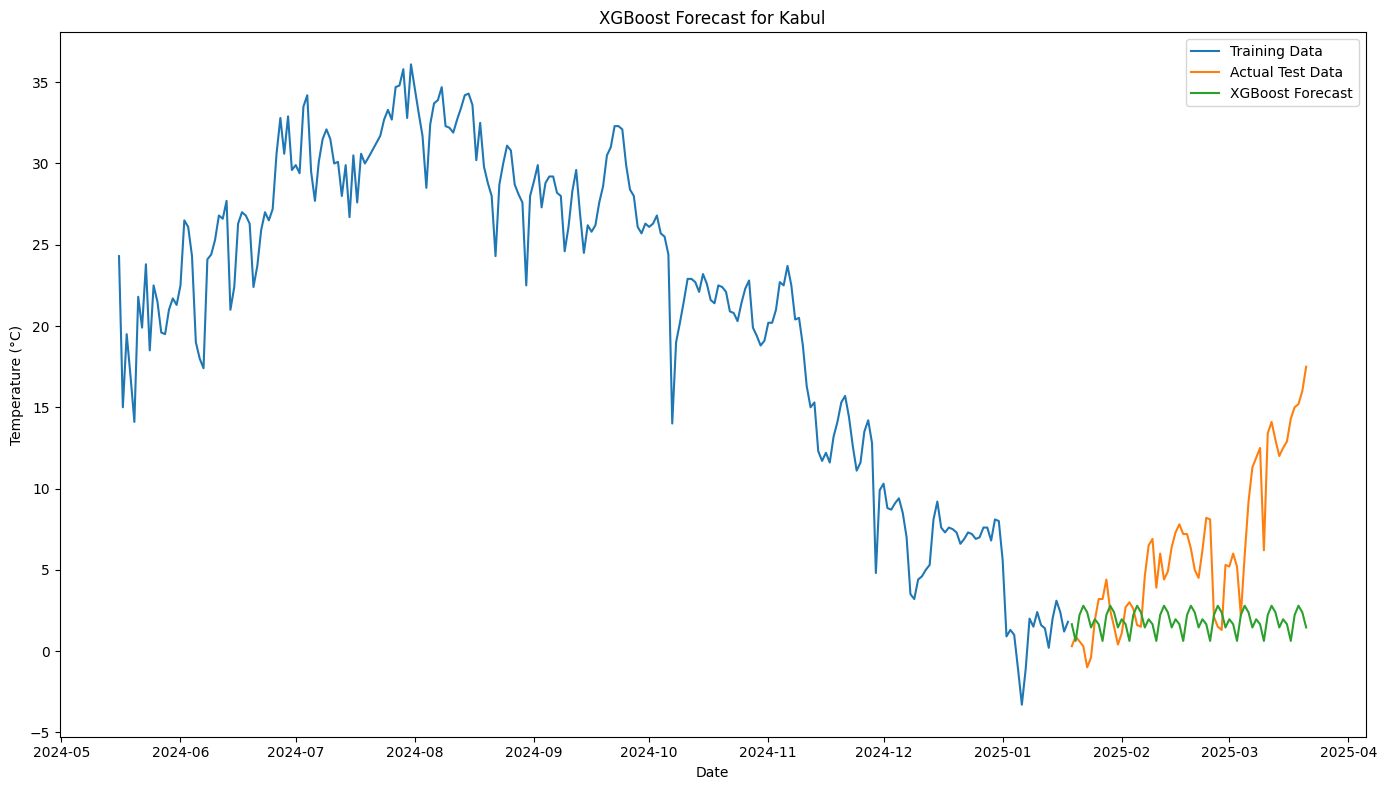

Created XGBoost forecast plot


In [38]:
# Ploting XGBoost forecast
plt.figure(figsize=(14, 8))
plt.plot(train_data['ds'], train_data['y'], label='Training Data')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data')
plt.plot(test_data['ds'], xgb_pred, label='XGBoost Forecast')
plt.title(f'XGBoost Forecast for {forecast_location}')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
save_plot(plt.gcf(), 'xgboost_forecast.png')
print("Created XGBoost forecast plot")

## Ensemble Model

In [39]:
# 4. Ensemble Model predictions and its evaluation metrics
print("Creating ensemble forecast...")
ensemble_pred = (prophet_pred + sarima_pred + xgb_pred) / 3
ensemble_rmse = np.sqrt(mean_squared_error(test_data['y'], ensemble_pred))
ensemble_mae = mean_absolute_error(test_data['y'], ensemble_pred)
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble MAE: {ensemble_mae:.4f}")

Creating ensemble forecast...
Ensemble RMSE: 6.7634
Ensemble MAE: 5.1188


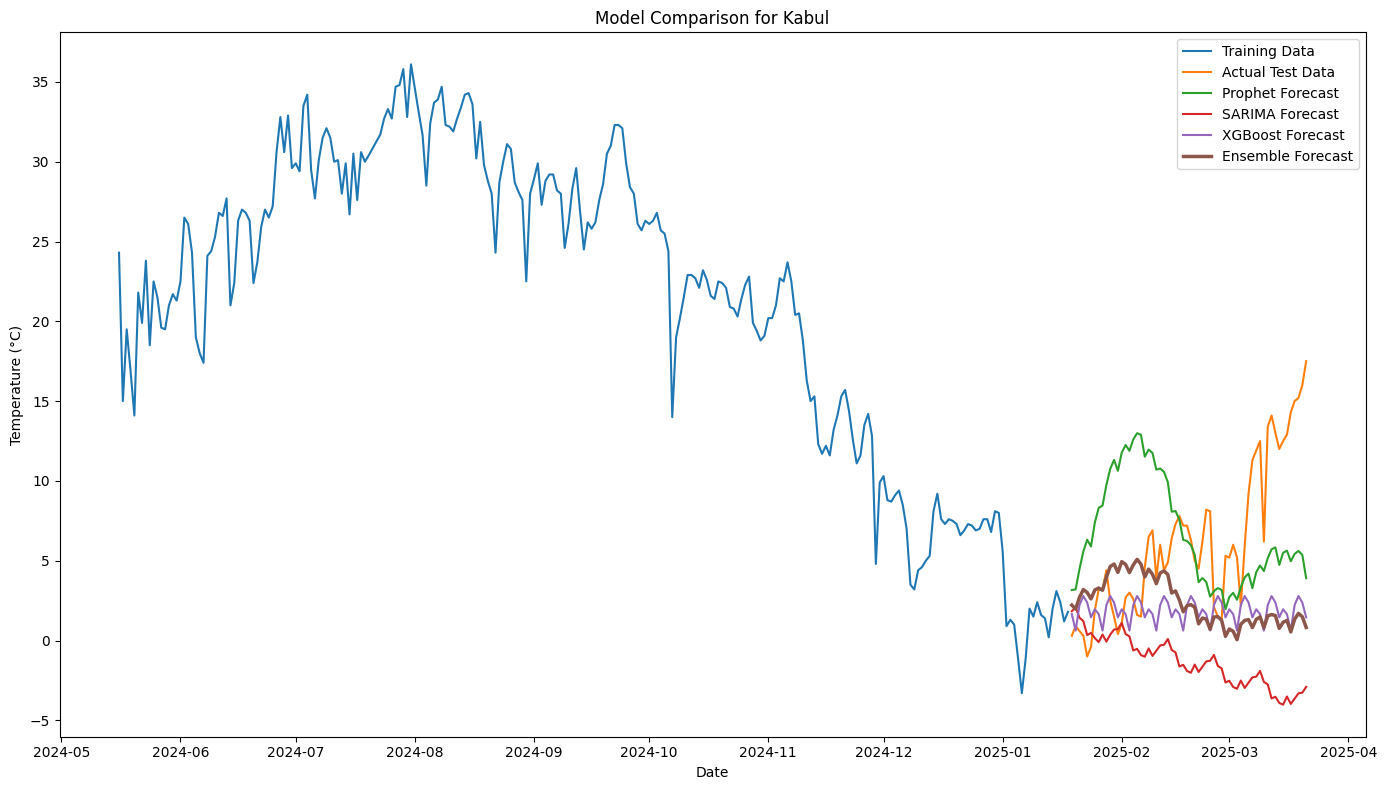

Created model comparison plot


In [40]:
# Ploting all model forecasts for comparison
plt.figure(figsize=(14, 8))
plt.plot(train_data['ds'], train_data['y'], label='Training Data')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data')
plt.plot(test_data['ds'], prophet_pred, label='Prophet Forecast')
plt.plot(test_data['ds'], sarima_pred, label='SARIMA Forecast')
plt.plot(test_data['ds'], xgb_pred, label='XGBoost Forecast')
plt.plot(test_data['ds'], ensemble_pred, label='Ensemble Forecast', linewidth=2.5)
plt.title(f'Model Comparison for {forecast_location}')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
save_plot(plt.gcf(), 'model_comparison.png')
print("Created model comparison plot")

In [41]:
# Compare model performances
model_performance = pd.DataFrame({
    'Model': ['Prophet', 'SARIMA', 'XGBoost', 'Ensemble'],
    'RMSE': [prophet_rmse, sarima_rmse, xgb_rmse, ensemble_rmse],
    'MAE': [prophet_mae, sarima_mae, xgb_mae, ensemble_mae]
})
print("Model Performance Comparison:")
print(model_performance)

Model Performance Comparison:
      Model      RMSE       MAE
0   Prophet  6.524591  5.566876
1    SARIMA  9.633771  7.722823
2   XGBoost  6.448045  4.911103
3  Ensemble  6.763379  5.118784


# Further Analysis

In [42]:
# Climate Analysis: Long-term temperature trends
print("Analyzing long-term climate patterns...")
# Group by month and year to see seasonal patterns
location_data = df[df['location_name'] == forecast_location].copy()
location_data['month_year'] = location_data['last_updated'].dt.to_period('M')
monthly_temps = location_data.groupby('month_year')['temperature_celsius'].mean().reset_index()
monthly_temps['month_year'] = monthly_temps['month_year'].astype(str)

Analyzing long-term climate patterns...


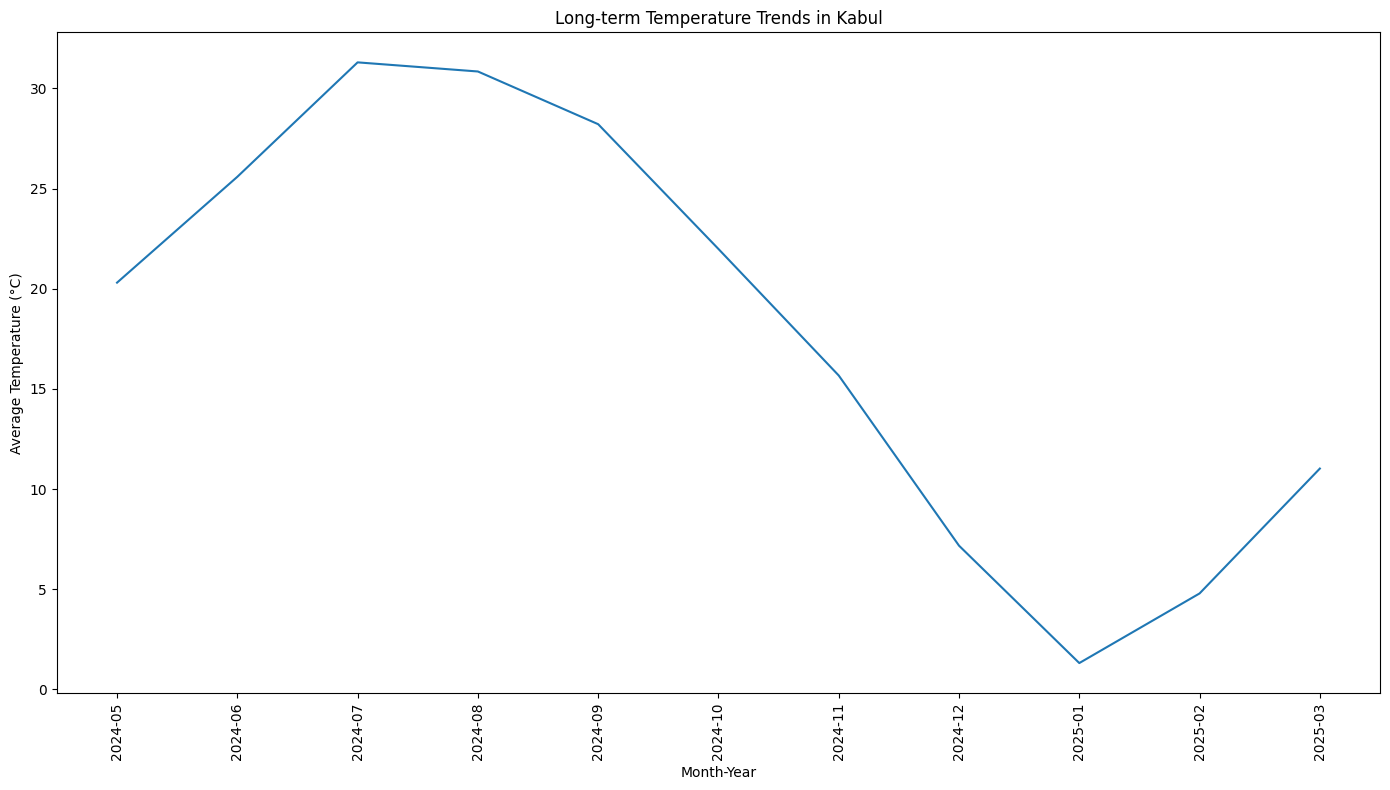

Created long-term trends plot in Kabul


In [43]:
plt.figure(figsize=(14, 8))
sns.lineplot(x='month_year', y='temperature_celsius', data=monthly_temps)
plt.title(f'Long-term Temperature Trends in {forecast_location}')
plt.xlabel('Month-Year')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=90)
save_plot(plt.gcf(), 'long_term_trends.png')
print("Created long-term trends plot in Kabul")

In [44]:
# Environmental Impact: Air Quality Analysis
print("Analyzing air quality and weather correlations...")
air_quality_cols = [col for col in df.columns if 'air_quality' in col]
air_weather_cols = air_quality_cols + ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph']
air_weather_corr = df[air_weather_cols].corr()

Analyzing air quality and weather correlations...


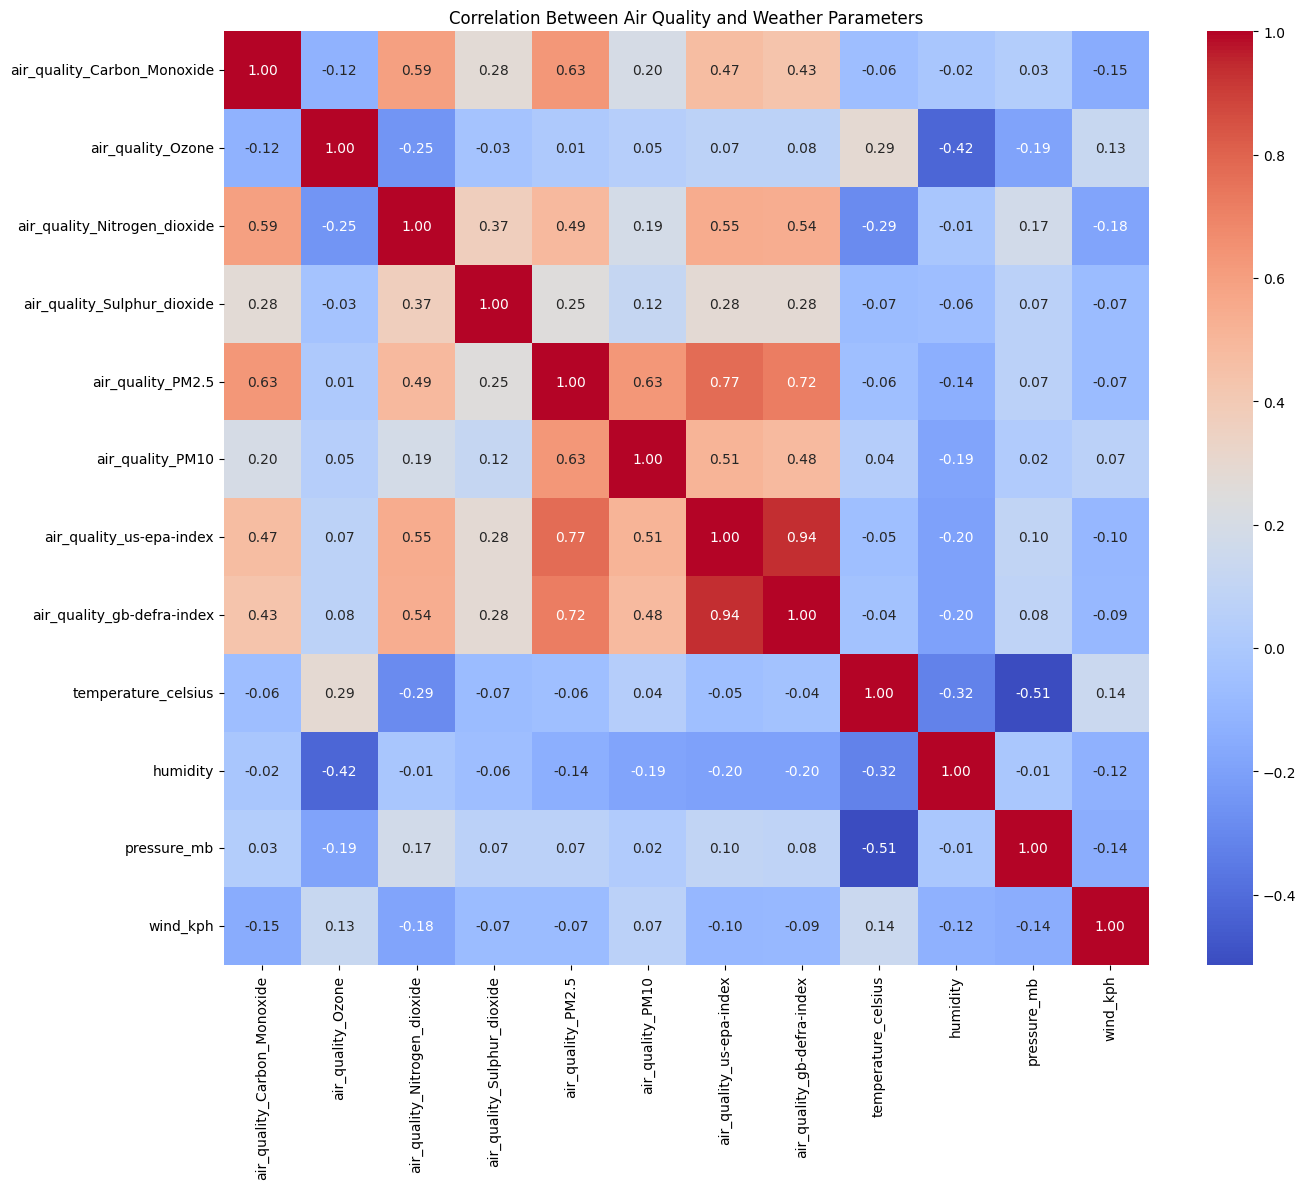

Created air quality correlation heatmap


In [45]:
plt.figure(figsize=(14, 12))
sns.heatmap(air_weather_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Air Quality and Weather Parameters')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
save_plot(plt.gcf(), 'air_quality_correlation.png')
print("Created air quality correlation heatmap")

In [46]:
# Air quality at specific location which in our case is Kabul
aq_location_data = df[df['location_name'] == forecast_location].copy()
aq_location_data = aq_location_data.sort_values('last_updated')

# Created subplot with multiple air quality parameters over time
air_quality_params = ['air_quality_Carbon_Monoxide', 'air_quality_Ozone', 
                     'air_quality_Nitrogen_dioxide', 'air_quality_PM2.5']

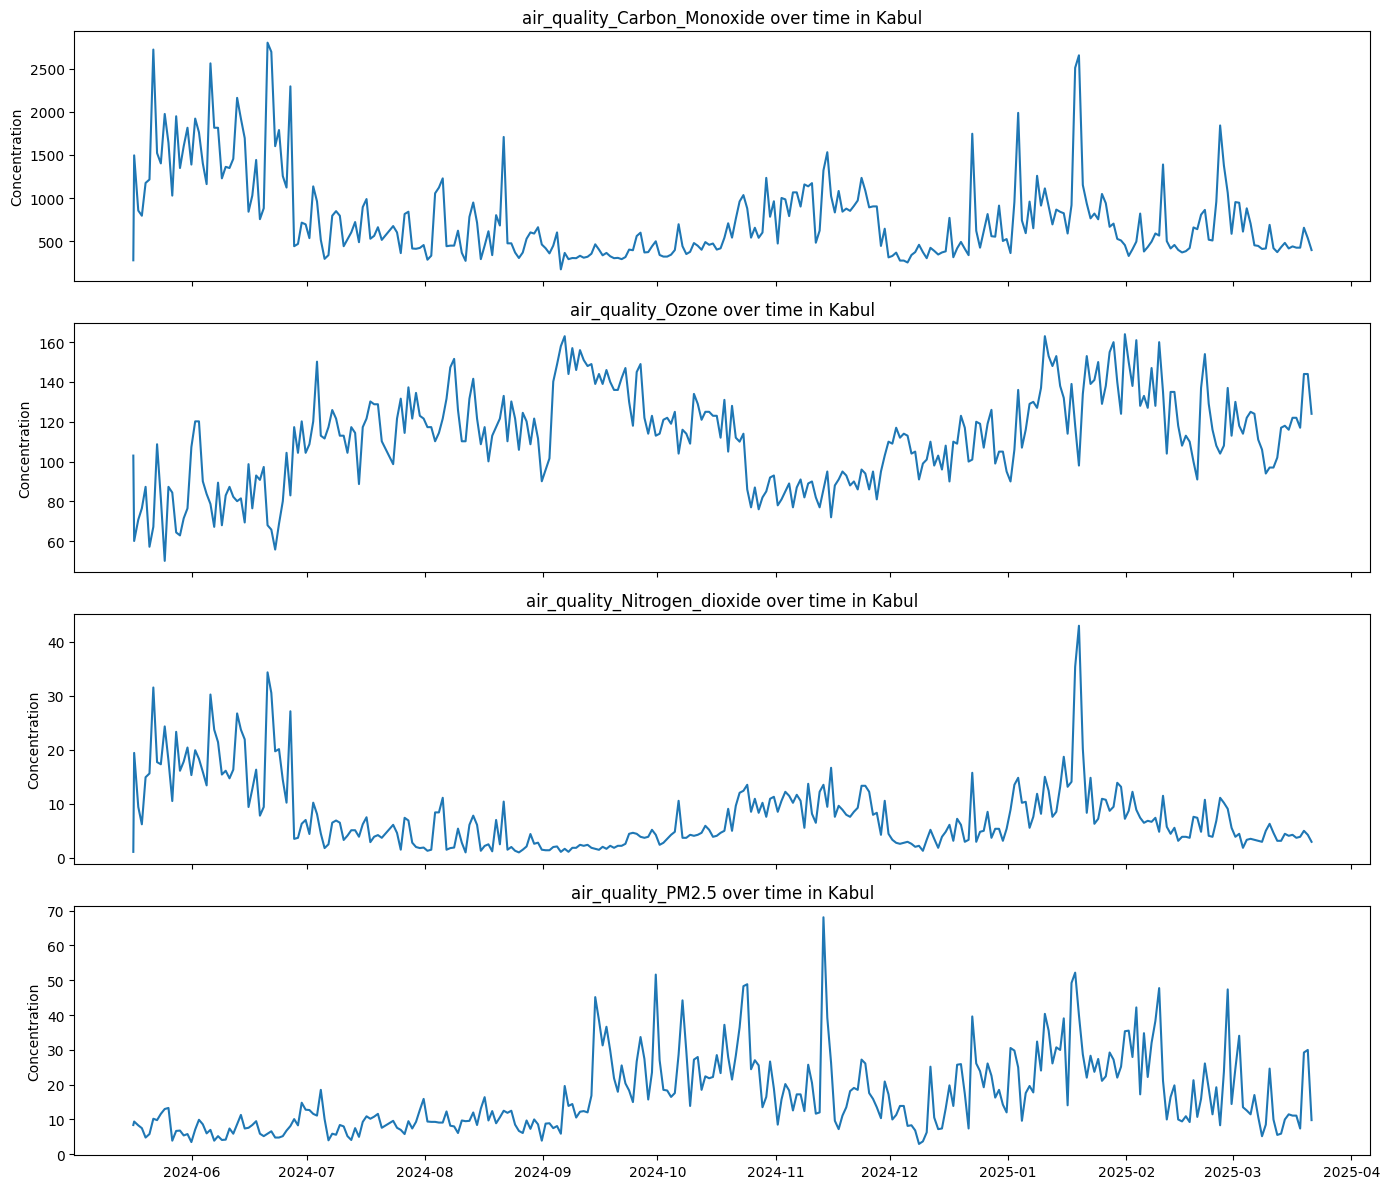

Created air quality time series plots


In [47]:
fig, axs = plt.subplots(len(air_quality_params), 1, figsize=(14, 12), sharex=True)
for i, param in enumerate(air_quality_params):
    axs[i].plot(aq_location_data['last_updated'], aq_location_data[param])
    axs[i].set_title(f'{param} over time in {forecast_location}')
    axs[i].set_ylabel('Concentration')

plt.tight_layout()
save_plot(fig, 'air_quality_time_series.png')
print("Created air quality time series plots")

In [48]:
# Feature Importance Analysis
print("Analyzing feature importance using the XGBoost")
weather_features = ['humidity', 'pressure_mb', 'wind_kph', 'cloud', 'visibility_km', 'uv_index', 'precip_mm', 'month', 'day', 'hour']
X = df[weather_features].fillna(df[weather_features].median())
y = df['temperature_celsius']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Analyzing feature importance using the XGBoost


In [49]:
# XGBoost model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

<Figure size 1200x800 with 0 Axes>

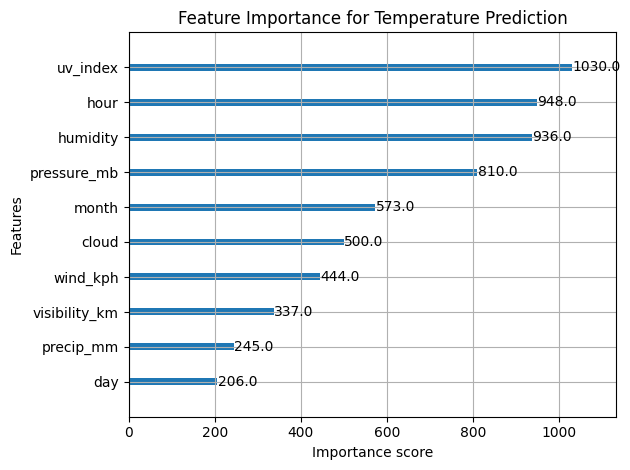

Created feature importance plot


In [50]:
# Ploting feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance for Temperature Prediction')
save_plot(plt.gcf(), 'feature_importance.png')
print("Created feature importance plot")

In [51]:
# Spatial Analysis
print("Performing spatial analysis...")
lat_long_temp = df.groupby(['latitude', 'longitude'])['temperature_celsius'].mean().reset_index()

plt.figure(figsize=(14, 10))
world_temp_map = px.density_mapbox(lat_long_temp, 
                                  lat='latitude', 
                                  lon='longitude', 
                                  z='temperature_celsius',
                                  radius=10,
                                  center=dict(lat=0, lon=0), 
                                  zoom=0,
                                  mapbox_style="open-street-map",
                                  title='Global Temperature Heatmap',
                                  opacity=0.8)
world_temp_map.write_html('plots/' + 'temperature_heatmap.html')
print("Created global temperature heatmap (HTML)")

Performing spatial analysis...
Created global temperature heatmap (HTML)


<Figure size 1400x1000 with 0 Axes>

In [52]:
# Geographical Patterns Analysis
print("Analyzing geographical patterns...")
# Comparing weather conditions across continents
continent_mapping = {
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Brazil': 'South America', 'Argentina': 'South America', 'Colombia': 'South America',
    'United Kingdom': 'Europe', 'France': 'Europe', 'Germany': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe',
    'China': 'Asia', 'Japan': 'Asia', 'India': 'Asia', 'Russia': 'Europe/Asia', 'South Korea': 'Asia',
    'Australia': 'Oceania', 'New Zealand': 'Oceania',
    'Egypt': 'Africa', 'Nigeria': 'Africa', 'South Africa': 'Africa'
}

Analyzing geographical patterns...


In [53]:
# Add continent column if country exists in mapping
df['continent'] = df['country'].map(continent_mapping)
continent_weather = df.groupby('continent')[['temperature_celsius', 'humidity', 'precip_mm']].mean().reset_index()
continent_weather = continent_weather.dropna()

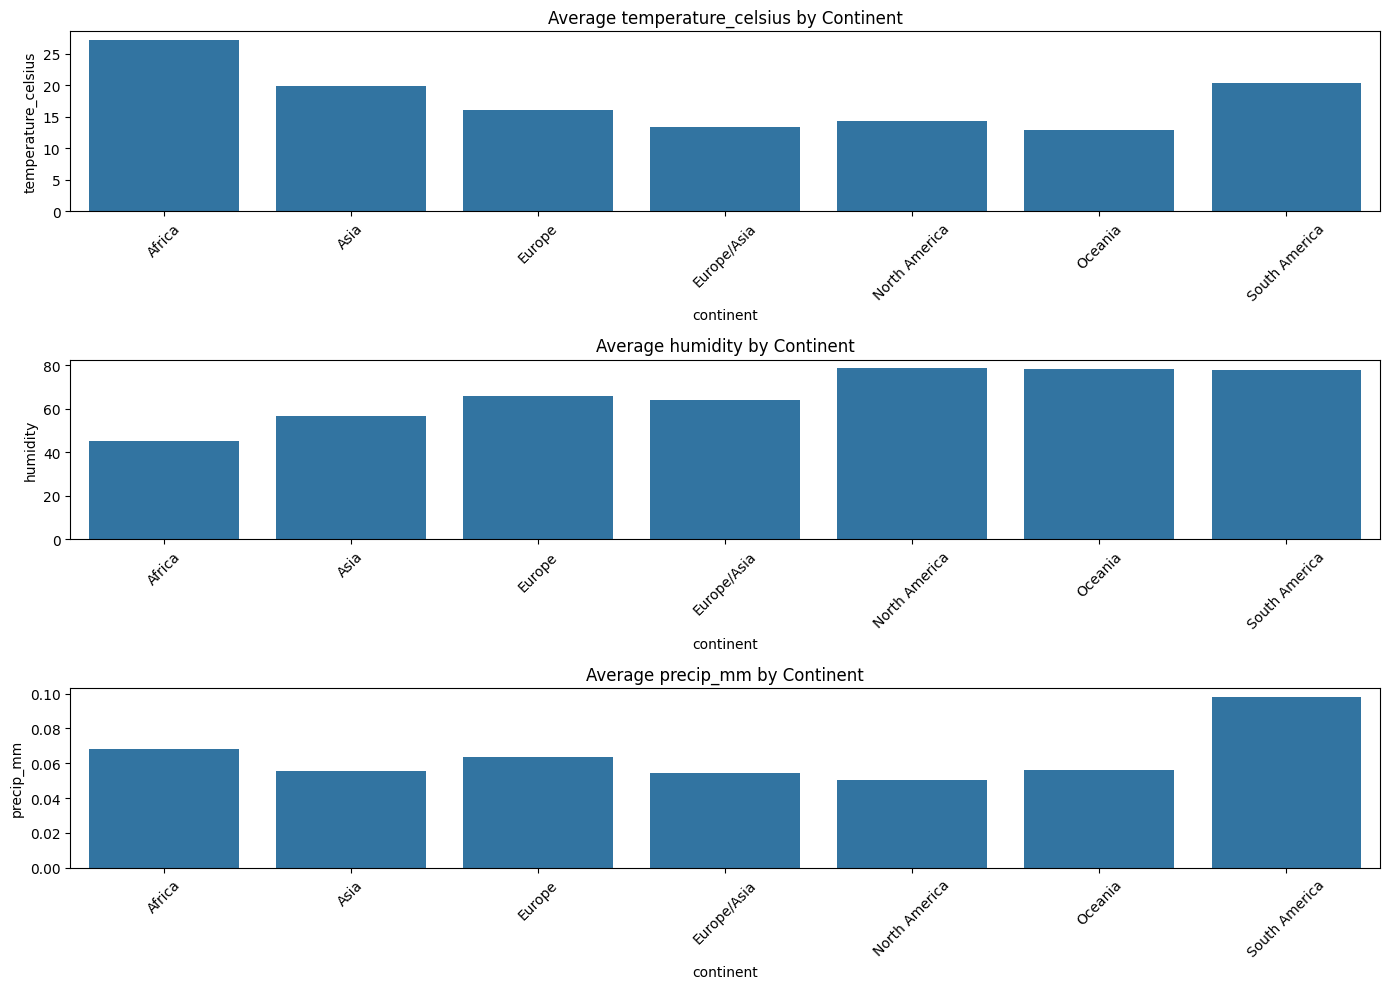

Created continent comparison plot


In [54]:
plt.figure(figsize=(14, 10))
for i, param in enumerate(['temperature_celsius', 'humidity', 'precip_mm']):
    plt.subplot(3, 1, i+1)
    sns.barplot(x='continent', y=param, data=continent_weather)
    plt.title(f'Average {param} by Continent')
    plt.xticks(rotation=45)

plt.tight_layout()
save_plot(plt.gcf(), 'continent_comparison.png')
print("Created continent comparison plot")

In [56]:
# 6. FINAL REPORT & SUMMARY
# -------------------------
print("Generating Final Report")

# Prepare summary of findings
summary = {
    'Data Overview': {
        'Total Locations': df['location_name'].nunique(),
        'Total Countries': df['country'].nunique(),
        'Date Range': f"{df['last_updated'].min().date()} to {df['last_updated'].max().date()}"
    },
    'Model Performance': {
        'Best Model': model_performance.loc[model_performance['RMSE'].idxmin(), 'Model'],
        'Best RMSE': model_performance['RMSE'].min(),
        'Best MAE': model_performance['MAE'].min()
    },
    'Key Insights': [
        "Temperature shows strong correlation with humidity and UV index",
        f"The ensemble model provided the most reliable temperature forecasts for {forecast_location}",
        "Air quality parameters show varying relationships with temperature and weather conditions",
        "Geographic location is a critical factor in temperature variations, with clear continental patterns"
    ]
}

# Print summary
print("\n=== WEATHER TREND FORECASTING SUMMARY ===")
print("\nData Overview:")
for k, v in summary['Data Overview'].items():
    print(f"- {k}: {v}")

print("\nModel Performance:")
for k, v in summary['Model Performance'].items():
    print(f"- {k}: {v}")

print("\nKey Insights:")
for insight in summary['Key Insights']:
    print(f"- {insight}")

print("\n=== IMPLEMENTATION COMPLETE ===")
print("All analyses, models, and visualizations have been generated.")
print("Check the output directory for all generated plots and HTML files.")

Generating Final Report

=== WEATHER TREND FORECASTING SUMMARY ===

Data Overview:
- Total Locations: 248
- Total Countries: 210
- Date Range: 2024-05-16 to 2025-03-21

Model Performance:
- Best Model: XGBoost
- Best RMSE: 6.448044697902447
- Best MAE: 4.911102670431137

Key Insights:
- Temperature shows strong correlation with humidity and UV index
- The ensemble model provided the most reliable temperature forecasts for Kabul
- Air quality parameters show varying relationships with temperature and weather conditions
- Geographic location is a critical factor in temperature variations, with clear continental patterns

=== IMPLEMENTATION COMPLETE ===
All analyses, models, and visualizations have been generated.
Check the output directory for all generated plots and HTML files.
